<a href="https://colab.research.google.com/github/ShreyNaik123/GAN-Implementations/blob/main/Pix2Pix_Incomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

##PADDING REFLECT IN TORCH HAS SAME SHAPE AS PADDING SAME IN TENSORFLOW

In [2]:
class Block(tf.keras.layers.Layer):
  def __init__(self, filters,down, relu, use_dropout=False):
    super(Block, self).__init__()
    self.conv = tf.keras.models.Sequential()
    if down:
      self.conv.add(layers.Conv2D(filters=filters,kernel_size=4,strides=(2,2), padding='same'))
    else:
      self.conv.add(layers.Conv2DTranspose(filters=filters,kernel_size=4,strides=(2,2), padding='same'))
    self.conv.add(layers.BatchNormalization())
    self.conv.add(layers.ReLU()) if relu else self.conv.add(layers.LeakyReLU())

    self.use_dropout = use_dropout
    self.dropout = layers.Dropout(0.5)

  def call(self, x):
    x = self.conv(x)
    return self.dropout(x) if self.use_dropout else x

In [3]:
class Generator(tf.keras.models.Model):
  def __init__(self, filters=64):
    super(Generator, self).__init__()
    # initial layer does not have batch normalization

    # encoder
    self.initial_layer = tf.keras.models.Sequential([ #<- input is 256
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
    ]) #128

    # ALL THESE BLOCKS HAVE KERNEL_SIZE OF 4 AND STRIDE OF 2

    self.down1 = Block(filters=128,down=True, relu=False, use_dropout=False) #64
    self.down2 = Block(filters=256,down=True, relu=False, use_dropout=False) #32
    self.down3 = Block(filters=512,down=True, relu=False, use_dropout=False) #16
    self.down4 = Block(filters=512,down=True, relu=False, use_dropout=False) #8
    self.down5 = Block(filters=512,down=True, relu=False, use_dropout=False) #4
    self.down6 = Block(filters=512,down=True, relu=False, use_dropout=False) #2

    self.bottleneck = tf.keras.models.Sequential([  #1x1
        layers.Conv2D(512, kernel_size=4, strides=2, padding='same'),
        tf.keras.layers.ReLU(),
    ])
    # unet decoder
    self.up1 = Block(filters=512,down=False, relu=True, use_dropout=True)
    self.up2 = Block(filters=1024,down=False, relu=True, use_dropout=True)
    self.up3 = Block(filters=1024,down=False, relu=True, use_dropout=True)
    self.up4 = Block(filters=1024,down=False, relu=True, use_dropout=False)
    self.up5 = Block(filters=1024,down=False, relu=True, use_dropout=False)
    self.up6 = Block(filters=512,down=False, relu=True, use_dropout=False)
    self.up7 = Block(filters=256,down=False, relu=True, use_dropout=False)
    self.last_up = tf.keras.models.Sequential([
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        layers.Conv2D(3,1), #to fix the number of ouput channels
        layers.Activation('tanh')
    ])


  def call(self, x):
    d1 = self.initial_layer(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)
    bottleneck = self.bottleneck(d7)
    up1 = self.up1(bottleneck)    #skip connections based on U-Net architecture
    up2 = self.up2(layers.Concatenate(axis=-1)([up1,d7]))
    up3 = self.up3(layers.Concatenate(axis=-1)([up2,d6]))
    up4 = self.up4(layers.Concatenate(axis=-1)([up3,d5]))
    up5 = self.up5(layers.Concatenate(axis=-1)([up4,d4]))
    up6 = self.up6(layers.Concatenate(axis=-1)([up5,d3]))
    up7 = self.up7(layers.Concatenate(axis=-1)([up6,d2]))
    return self.last_up(layers.Concatenate(axis=-1)([up7,d1]))


  def model(self):
    x = layers.Input(shape=(256,256,3))
    return tf.keras.models.Model([x], self.call(x))


In [4]:
x = tf.random.uniform((1,256,256,3))
model = Generator(filters=64)
preds = model(x)
print(preds.shape)

(1, 256, 256, 3)


In [5]:
from tensorflow.keras.utils import plot_model

In [6]:
model.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3136      ['input_1[0][0]']             
                                                                                                  
 block (Block)               (None, 64, 64, 128)          131712    ['sequential[0][0]']          
                                                                                                  
 block_1 (Block)             (None, 32, 32, 256)          525568    ['block[0][0]']               
                                                                                              

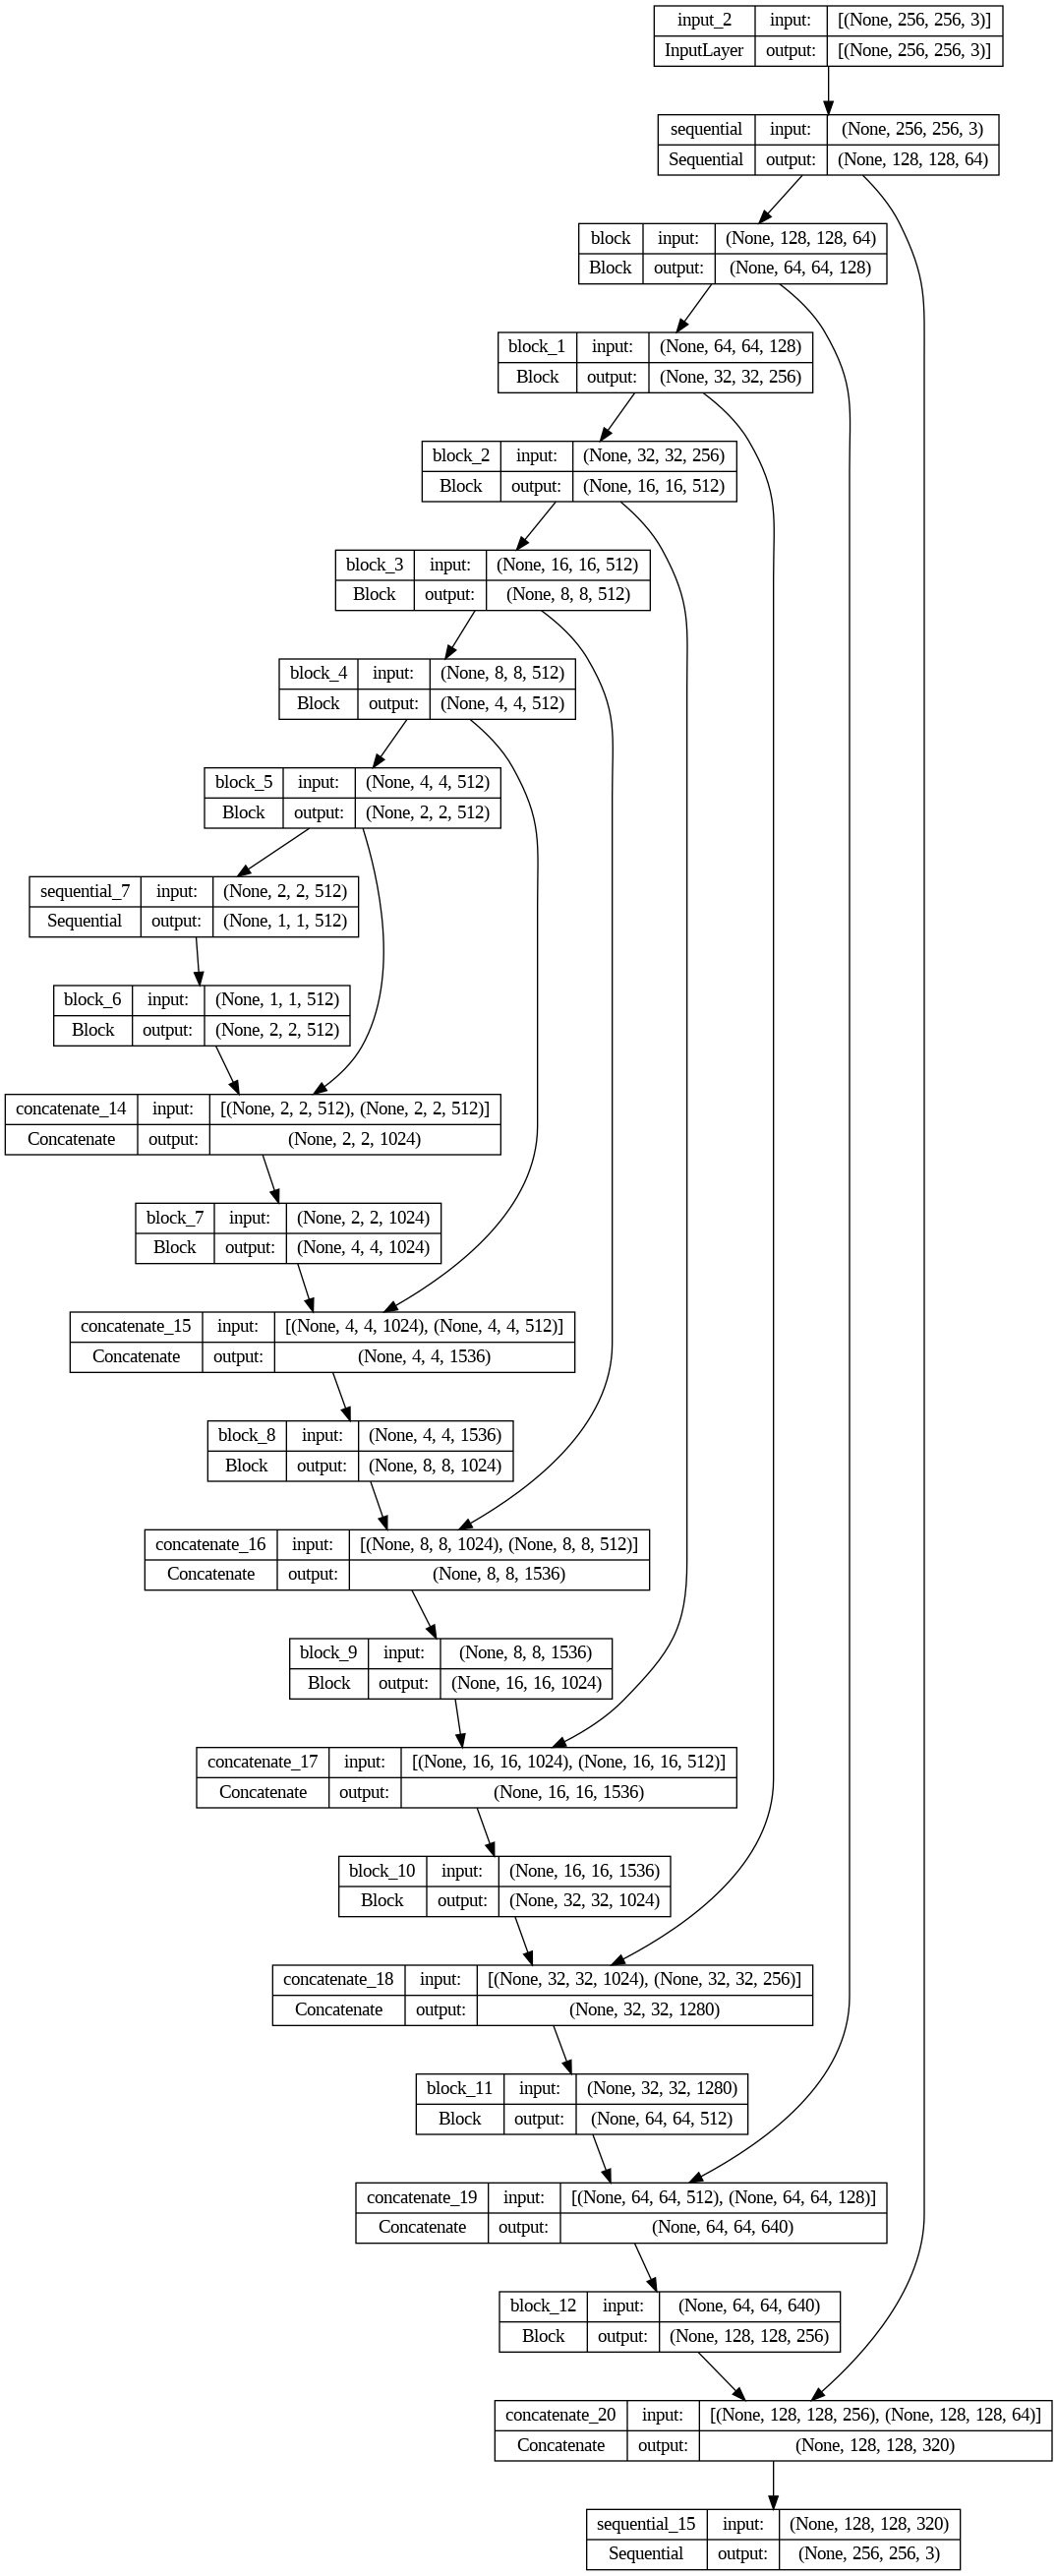

In [7]:
plot_model(model.model(), show_shapes=True)

In [8]:
  class CNNBlock(layers.Layer):
    def __init__(self, filters,strides):
      super(CNNBlock, self).__init__()
      self.cnn = tf.keras.models.Sequential([
          layers.Conv2D(filters=filters, kernel_size=4, strides=(strides, strides), padding='same'),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
      ])


    def call(self,x):
      return self.cnn(x)

In [9]:
class Discriminator(tf.keras.models.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = tf.keras.models.Sequential([
        layers.Conv2D(filters=64, kernel_size=4, strides=(2,2),padding='same'),
        layers.LeakyReLU(0.2),
    ])

    self.conv2 = CNNBlock(filters=128, strides=2)
    self.conv3 = CNNBlock(filters=256, strides=2)
    self.conv4 = CNNBlock(filters=512, strides=1)
    self.final = layers.Conv2D(1, 4,strides=1,activation='sigmoid',padding='same')

  def call(self, x,y):
    x = layers.Concatenate(axis=-1)([x,y])
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)

    return self.final(x)

  def model(self):
    x = layers.Input(shape=(256,256,3))
    y = layers.Input(shape=(256,256,3))
    return tf.keras.models.Model([x, y], self.call(x,y))

In [10]:
model = Discriminator()
x = tf.random.uniform((1,256,256,3))
y = tf.random.uniform((1,256,256,3))
pred = model(x,y)
print(pred.shape)

(1, 32, 32, 1)


In [11]:
model.model().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_22 (Concatenat  (None, 256, 256, 6)          0         ['input_3[0][0]',             
 e)                                                                  'input_4[0][0]']             
                                                                                                  
 sequential_16 (Sequential)  (None, 128, 128, 64)         6208      ['concatenate_22[0][0]']

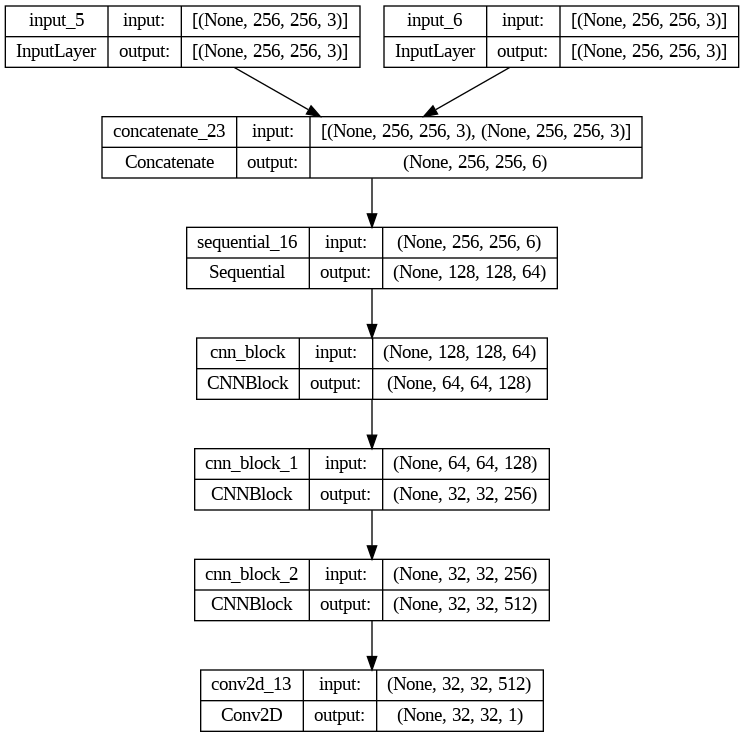

In [12]:
plot_model(model.model(), show_shapes=True)

##load and prep the images

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [14]:
!gdown --id 18aOUuJVV6kIgpnqKoP-AW3cY6ZxhP9Aa

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18aOUuJVV6kIgpnqKoP-AW3cY6ZxhP9Aa
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 409kB/s]


In [15]:
!kaggle datasets download alincijov/pix2pix-maps

 91% 217M/239M [00:01<00:00, 116MB/s]
100% 239M/239M [00:01<00:00, 126MB/s]


In [16]:
import zipfile
zip_ref = zipfile.ZipFile('/content/pix2pix-maps.zip')
zip_ref.extractall()
zip_ref.close()

In [17]:
image = np.array(Image.open('/content/train/1.jpg'))
print(image.shape)

(600, 1200, 3)


In [18]:
train_path = '/content/train'

In [19]:
len(os.listdir(train_path))

1096

In [20]:
def loader():
  for image in os.listdir(train_path):
    image = np.array(Image.open(os.path.join(train_path,image)))
    X,y = image[:,:600,:], image[:,600:,:]
    yield X,y

In [21]:
ds = tf.data.Dataset.from_generator(loader, output_shapes=((600, 600, 3),(600, 600, 3)),output_types=(tf.float64, tf.float64))

In [22]:
def rescale_resize(X,y):
  X = tf.image.resize(X, [256,256])
  y = tf.image.resize(y, [256,256])
  return (X-127.5)/127.5, (y-127.5)/127.5

In [23]:
def augment_image(image):
  image = tf.image.flip_left_right(image)
  return image

In [24]:
ds = ds.map(rescale_resize, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
augmented_ds = ds.map(lambda x,y : (augment_image(x), augment_image(y)),  num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
combined_ds = ds.concatenate(augmented_ds)

In [27]:
len(list(combined_ds))

2192

In [28]:
dataset = combined_ds.shuffle(500).batch(16).prefetch(tf.data.AUTOTUNE)

##create the model

In [29]:
bce = tf.keras.losses.BinaryCrossentropy()
l1 = tf.keras.losses.MeanAbsoluteError()

# original learning rate = 2e-4 changing it to 2e-2
g_opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-2, beta_1=0.5, beta_2=0.999)
d_opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-2, beta_1=0.5, beta_2=0.999)

In [30]:
save_folder = '/content/drive/MyDrive/pix2pix_model_saves'

In [31]:
data = dataset.take(1)

In [62]:
import matplotlib.pyplot as plt
class ShowResultsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ShowResultsCallback, self).__init__()
        self.save_folder = save_folder

    def on_epoch_end(self, epoch, logs=None):
            data = dataset.take(1)
            i = 0
            for input, output in data:
              for _ in range(4):
                  j = i
                  plt.subplot(4, 3, i + 1)
                  plt.imshow((input[j].numpy() * 0.5 + 0.5))  # Normalize to [0, 1]
                  plt.axis(False)
                  i += 1
                  plt.subplot(4, 3, i + 1)
                  plt.imshow((output[j].numpy() *0.5 + 0.5))
                  plt.axis(False)
                  i += 1
                  plt.subplot(4, 3, i + 1)
                  pred = self.model.generator(tf.expand_dims(input[j], axis=0))
                  plt.imshow((tf.squeeze(pred).numpy() * 0.5 + 0.5))  # Normalize to [0, 1]
                  plt.axis(False)
                  i += 1
            plt.show()

In [34]:
class Pix2pix(tf.keras.models.Model):
  def __init__(self, generator, discriminator):
    super(Pix2pix,self).__init__()
    self.generator = generator
    self.discriminator = discriminator

  def compile(self,bce,l1,g_opt,d_opt):
    super().compile()
    self.bce = bce
    self.l1 = l1
    self.g_opt = g_opt
    self.d_opt = d_opt



  def train_step(self, batch):
    X,y = batch
    input = X
    real_image = y

    with tf.GradientTape() as d_tape:
      gen_image = self.generator(input, training=False)

      pred_true = self.discriminator(input,real_image, training=True)
      pred_fake = self.discriminator(input,gen_image, training=True)

      # real image -> 0
      # fake image -> 1

      true_preds = tf.zeros(tf.shape(pred_true))
      fake_preds = tf.ones(tf.shape(pred_fake))

      true_loss = self.bce(true_preds,pred_true)
      fake_loss = self.bce(fake_preds,pred_fake)

      d_total_loss = (true_loss + fake_loss)/2

    d_gradient = d_tape.gradient(d_total_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))


    with tf.GradientTape() as g_tape:
      gen_image = self.generator(input, training=True)
      pred = self.discriminator(input,gen_image,training=False)
      true_preds = tf.zeros(tf.shape(pred_true))
      bce_loss = self.bce(true_preds, pred)
      g_total_loss = bce_loss + self.l1(true_preds, pred)*100
      # 100 is the lambda constant pix2pix paper used

    g_gradient = g_tape.gradient(g_total_loss, self.discriminator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_gradient, self.discriminator.trainable_variables))

    return {'d_loss':d_total_loss, 'g_loss':g_total_loss}

In [35]:
generator = Generator()
discriminator = Discriminator()
p2p = Pix2pix(generator, discriminator)

In [36]:
p2p.compile(bce,l1,g_opt,d_opt)

In [55]:
def show_images():
  data = dataset.take(1)
  i = 0
  for input, output in data:
      for _ in range(4):
          j = i
          plt.subplot(4, 3, i + 1)
          plt.imshow((input[j].numpy() * 0.5 + 0.5))  # Normalize to [0, 1]
          plt.axis(False)
          i += 1
          plt.subplot(4, 3, i + 1)
          plt.imshow((output[j].numpy() *0.5 + 0.5))
          plt.axis(False)
          i += 1
          plt.subplot(4, 3, i + 1)
          pred = p2p.generator(tf.expand_dims(input[j], axis=0))
          plt.imshow((tf.squeeze(pred).numpy() * 0.5 + 0.5))  # Normalize to [0, 1]
          plt.axis(False)
          i += 1

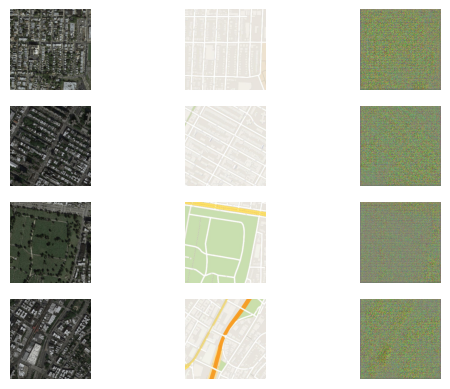

In [56]:
show_images()

In [38]:
# p2p.fit(dataset, epochs=100, callbacks=[ShowResultsCallback()])

Epoch 1/15
137/137 [==============================] - 206s 1s/step - d_loss: 4.7197e-04 - g_loss: 2.7627e-05
Epoch 2/15
137/137 [==============================] - 202s 1s/step - d_loss: 3.6774e-04 - g_loss: 2.1028e-05
Epoch 3/15
137/137 [==============================] - 204s 1s/step - d_loss: 3.0038e-04 - g_loss: 1.8038e-05
Epoch 4/15
137/137 [==============================] - 201s 1s/step - d_loss: 2.4861e-04 - g_loss: 1.4916e-05
Epoch 5/15
137/137 [==============================] - 204s 1s/step - d_loss: 2.0541e-04 - g_loss: 1.2575e-05
Epoch 6/15
137/137 [==============================] - 203s 1s/step - d_loss: 1.7867e-04 - g_loss: 1.1200e-05
Epoch 7/15
137/137 [==============================] - 202s 1s/step - d_loss: 1.5461e-04 - g_loss: 9.7815e-06
Epoch 8/15
137/137 [==============================] - 204s 1s/step - d_loss: 1.3424e-04 - g_loss: 8.5355e-06
Epoch 9/15
137/137 [==============================] - 204s 1s/step - d_loss: 1.1692e-04 - g_loss: 7.8224e-06
Epoch 10/15
137/137

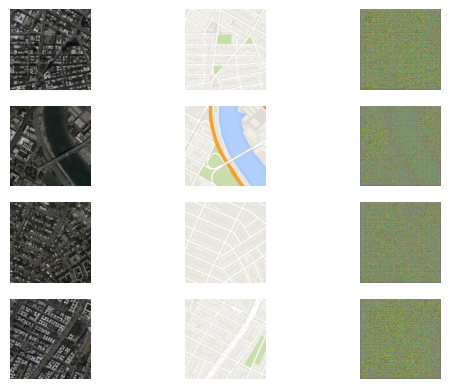

In [60]:
# 0-15 epochs
num_epochs = 15
p2p.fit(dataset, epochs=num_epochs,callbacks=[ShowResultsCallback()])

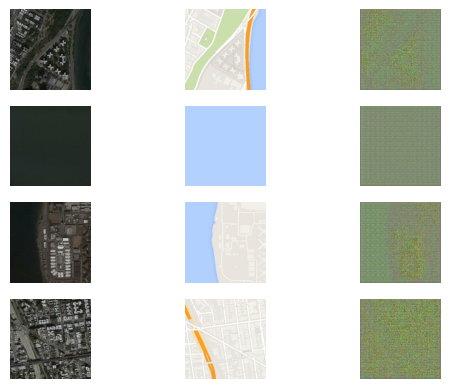

In [61]:
show_images()

Epoch 1/15
    137/Unknown - 196s 1s/step - d_loss: 5.3379e-05 - g_loss: 3.6703e-06

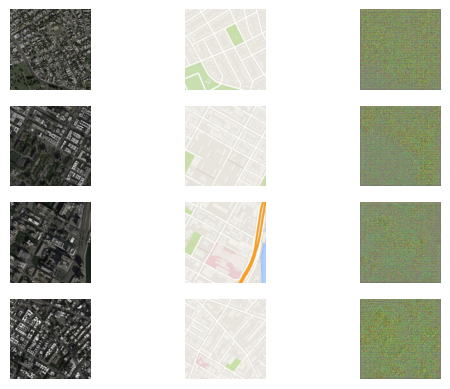

137/137 [==============================] - 202s 1s/step - d_loss: 5.3318e-05 - g_loss: 3.6531e-06
Epoch 2/15
137/137 [==============================] - ETA: 0s - d_loss: 4.9067e-05 - g_loss: 3.4117e-06

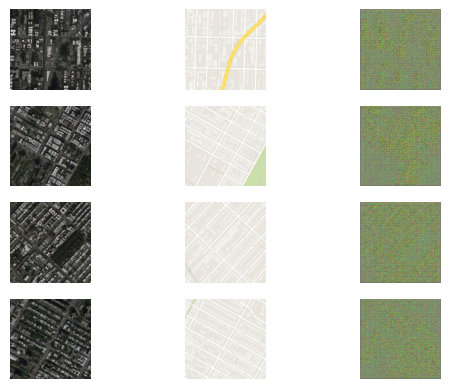

137/137 [==============================] - 204s 1s/step - d_loss: 4.9004e-05 - g_loss: 3.4038e-06
Epoch 3/15
137/137 [==============================] - ETA: 0s - d_loss: 4.4224e-05 - g_loss: 3.0309e-06

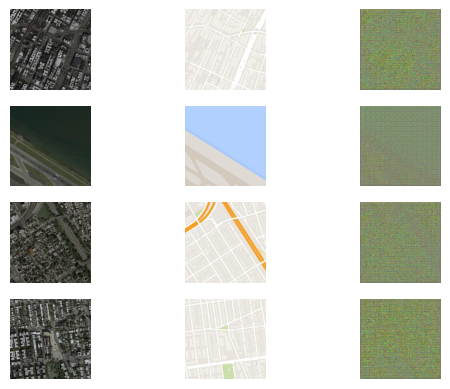

137/137 [==============================] - 204s 1s/step - d_loss: 4.4217e-05 - g_loss: 3.0225e-06
Epoch 4/15
137/137 [==============================] - ETA: 0s - d_loss: 4.0314e-05 - g_loss: 2.8084e-06

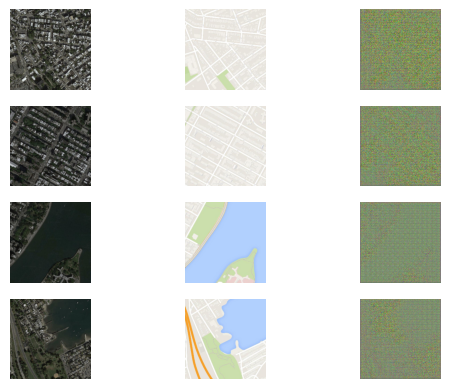

137/137 [==============================] - 204s 1s/step - d_loss: 4.0272e-05 - g_loss: 2.8067e-06
Epoch 5/15
137/137 [==============================] - ETA: 0s - d_loss: 3.6654e-05 - g_loss: 2.5497e-06

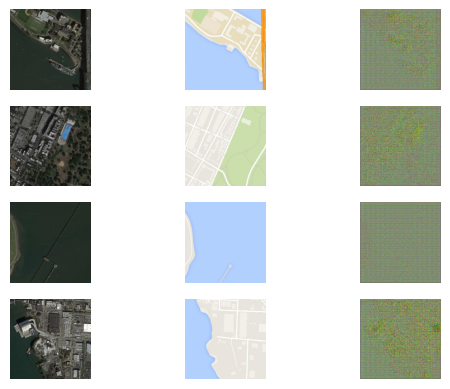

137/137 [==============================] - 202s 1s/step - d_loss: 3.6569e-05 - g_loss: 2.5419e-06
Epoch 6/15
137/137 [==============================] - ETA: 0s - d_loss: 3.4436e-05 - g_loss: 2.3671e-06

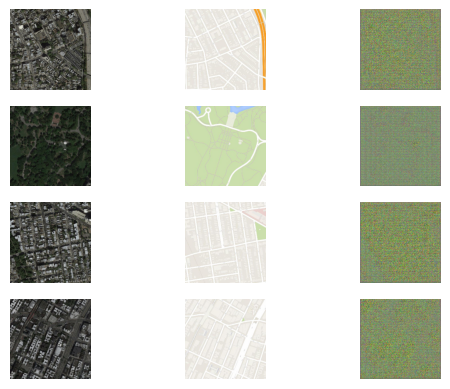

137/137 [==============================] - 204s 1s/step - d_loss: 3.4457e-05 - g_loss: 2.3696e-06
Epoch 7/15
137/137 [==============================] - ETA: 0s - d_loss: 3.1434e-05 - g_loss: 2.1563e-06

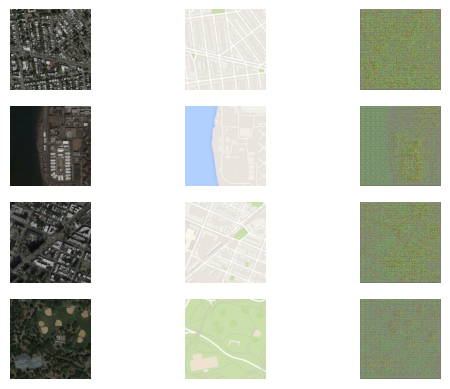

137/137 [==============================] - 204s 1s/step - d_loss: 3.1372e-05 - g_loss: 2.1467e-06
Epoch 8/15
137/137 [==============================] - ETA: 0s - d_loss: 2.8299e-05 - g_loss: 2.0157e-06

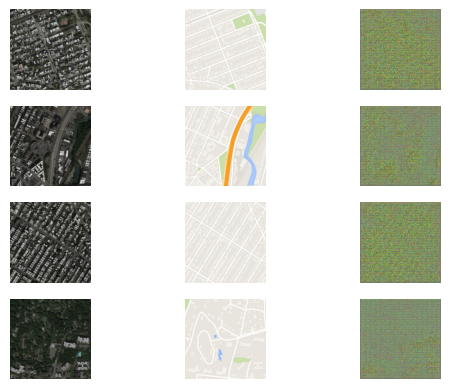

137/137 [==============================] - 203s 1s/step - d_loss: 2.8292e-05 - g_loss: 2.0083e-06
Epoch 9/15
137/137 [==============================] - ETA: 0s - d_loss: 2.6166e-05 - g_loss: 1.8230e-06

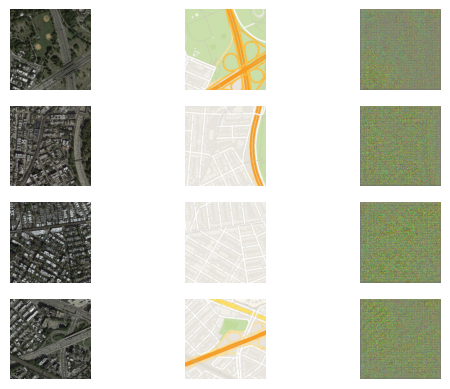

137/137 [==============================] - 204s 1s/step - d_loss: 2.6186e-05 - g_loss: 1.8206e-06
Epoch 10/15
137/137 [==============================] - ETA: 0s - d_loss: 2.4011e-05 - g_loss: 1.7102e-06

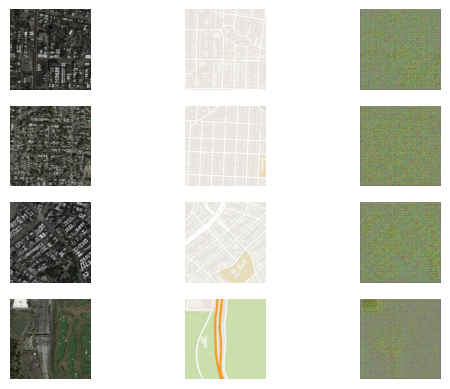

137/137 [==============================] - 203s 1s/step - d_loss: 2.3990e-05 - g_loss: 1.7050e-06
Epoch 11/15
137/137 [==============================] - ETA: 0s - d_loss: 2.1529e-05 - g_loss: 1.5202e-06

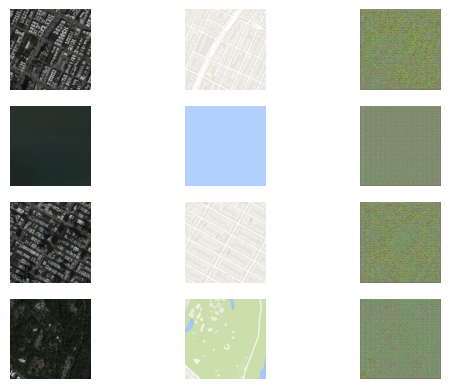

137/137 [==============================] - 202s 1s/step - d_loss: 2.1485e-05 - g_loss: 1.5150e-06
Epoch 12/15
137/137 [==============================] - ETA: 0s - d_loss: 2.0450e-05 - g_loss: 1.4458e-06

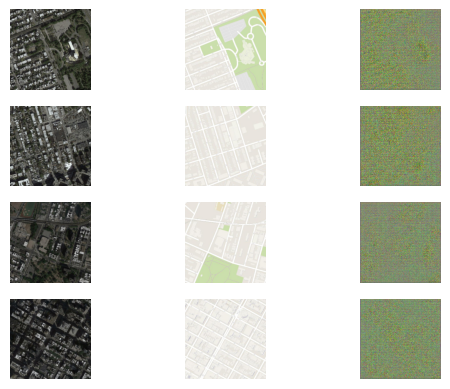

137/137 [==============================] - 206s 1s/step - d_loss: 2.0474e-05 - g_loss: 1.4488e-06
Epoch 13/15
137/137 [==============================] - ETA: 0s - d_loss: 1.8339e-05 - g_loss: 1.2716e-06

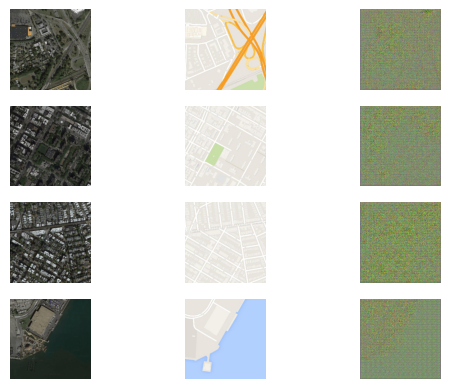

137/137 [==============================] - 207s 1s/step - d_loss: 1.8311e-05 - g_loss: 1.2735e-06
Epoch 14/15
137/137 [==============================] - ETA: 0s - d_loss: 1.6990e-05 - g_loss: 1.1981e-06

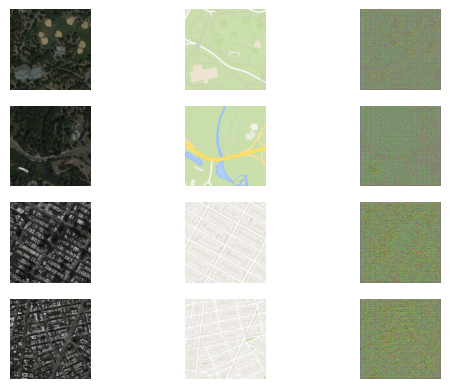

137/137 [==============================] - 204s 1s/step - d_loss: 1.6989e-05 - g_loss: 1.1938e-06
Epoch 15/15
137/137 [==============================] - ETA: 0s - d_loss: 1.5730e-05 - g_loss: 1.1103e-06

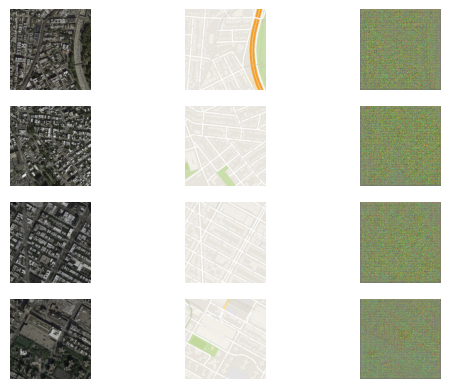

137/137 [==============================] - 203s 1s/step - d_loss: 1.5742e-05 - g_loss: 1.1107e-06


In [63]:
# 15-30 epochs
num_epochs = 15
p2p.fit(dataset, epochs=num_epochs,callbacks=[ShowResultsCallback()])

Epoch 1/15
    137/Unknown - 197s 1s/step - d_loss: 1.4262e-05 - g_loss: 1.0013e-06

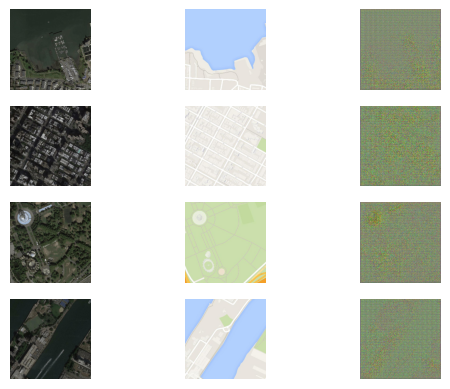

137/137 [==============================] - 204s 1s/step - d_loss: 1.4240e-05 - g_loss: 9.9798e-07
Epoch 2/15
137/137 [==============================] - ETA: 0s - d_loss: 1.3411e-05 - g_loss: 9.4713e-07

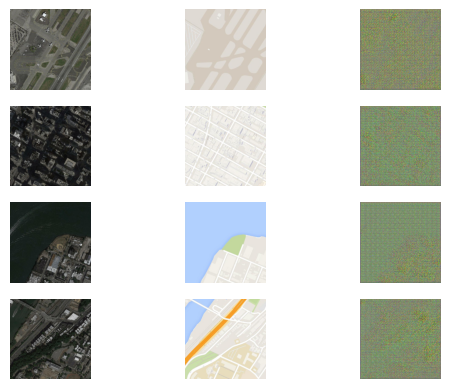

137/137 [==============================] - 204s 1s/step - d_loss: 1.3406e-05 - g_loss: 9.4686e-07
Epoch 3/15
137/137 [==============================] - ETA: 0s - d_loss: 1.2656e-05 - g_loss: 8.7832e-07

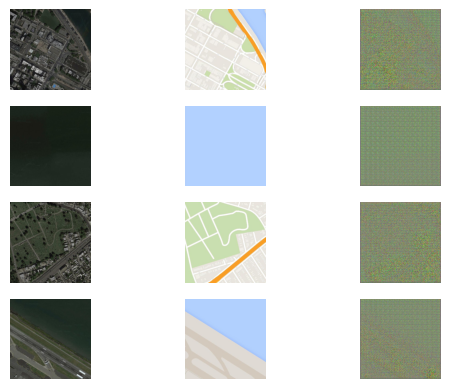

137/137 [==============================] - 203s 1s/step - d_loss: 1.2640e-05 - g_loss: 8.7941e-07
Epoch 4/15
137/137 [==============================] - ETA: 0s - d_loss: 1.1498e-05 - g_loss: 8.1157e-07

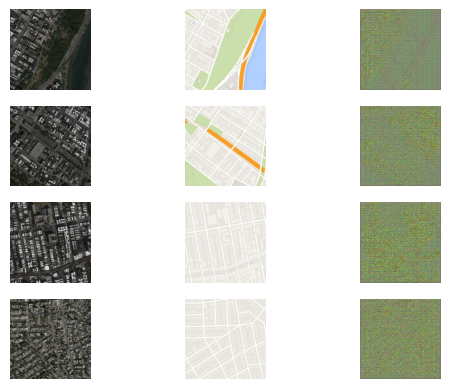

137/137 [==============================] - 204s 1s/step - d_loss: 1.1537e-05 - g_loss: 8.1612e-07
Epoch 5/15
137/137 [==============================] - ETA: 0s - d_loss: 1.0752e-05 - g_loss: 7.4421e-07

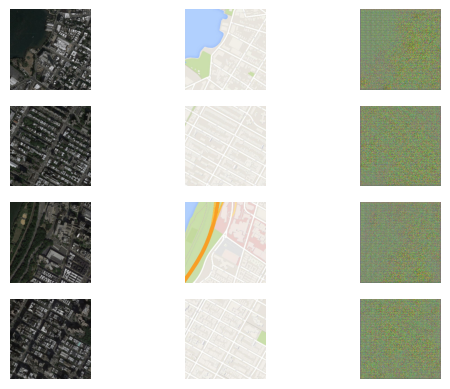

137/137 [==============================] - 204s 1s/step - d_loss: 1.0731e-05 - g_loss: 7.4292e-07
Epoch 6/15
137/137 [==============================] - ETA: 0s - d_loss: 9.7624e-06 - g_loss: 6.6484e-07

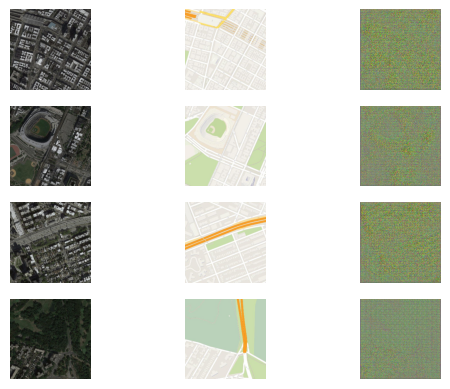

137/137 [==============================] - 207s 1s/step - d_loss: 9.7682e-06 - g_loss: 6.6511e-07
Epoch 7/15
137/137 [==============================] - ETA: 0s - d_loss: 9.2608e-06 - g_loss: 6.6884e-07

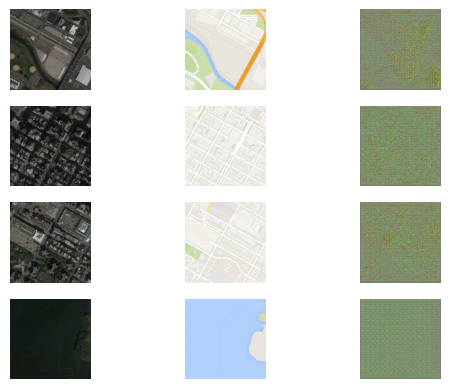

137/137 [==============================] - 204s 1s/step - d_loss: 9.2408e-06 - g_loss: 6.6866e-07
Epoch 8/15
137/137 [==============================] - ETA: 0s - d_loss: 8.3633e-06 - g_loss: 5.8574e-07

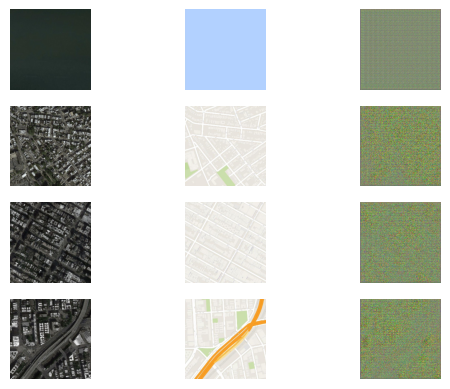

137/137 [==============================] - 203s 1s/step - d_loss: 8.3490e-06 - g_loss: 5.8401e-07
Epoch 9/15
137/137 [==============================] - ETA: 0s - d_loss: 7.9930e-06 - g_loss: 5.5112e-07

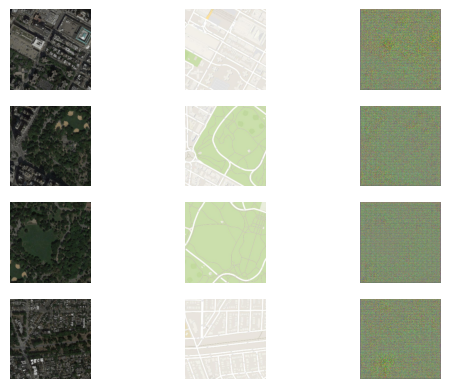

137/137 [==============================] - 204s 1s/step - d_loss: 7.9970e-06 - g_loss: 5.5313e-07
Epoch 10/15
137/137 [==============================] - ETA: 0s - d_loss: 7.2641e-06 - g_loss: 5.0365e-07

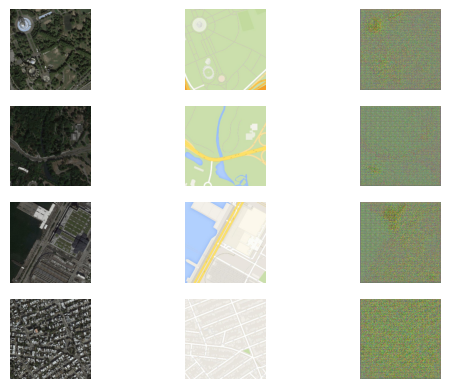

137/137 [==============================] - 205s 1s/step - d_loss: 7.2715e-06 - g_loss: 5.0333e-07
Epoch 11/15
137/137 [==============================] - ETA: 0s - d_loss: 6.7370e-06 - g_loss: 4.7651e-07

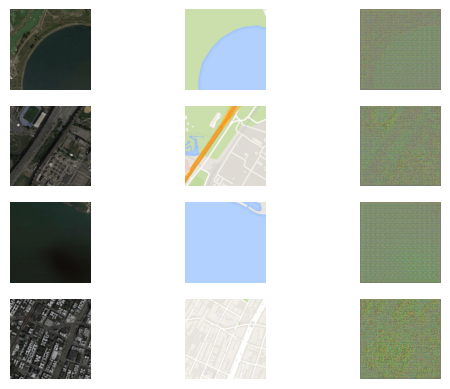

137/137 [==============================] - 204s 1s/step - d_loss: 6.7298e-06 - g_loss: 4.7490e-07
Epoch 12/15
137/137 [==============================] - ETA: 0s - d_loss: 6.1935e-06 - g_loss: 4.2448e-07

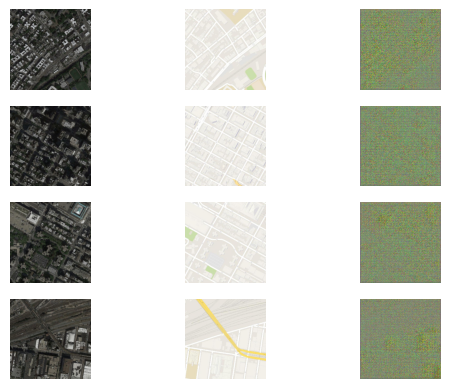

137/137 [==============================] - 207s 1s/step - d_loss: 6.1936e-06 - g_loss: 4.2838e-07
Epoch 13/15
137/137 [==============================] - ETA: 0s - d_loss: 5.8398e-06 - g_loss: 3.9249e-07

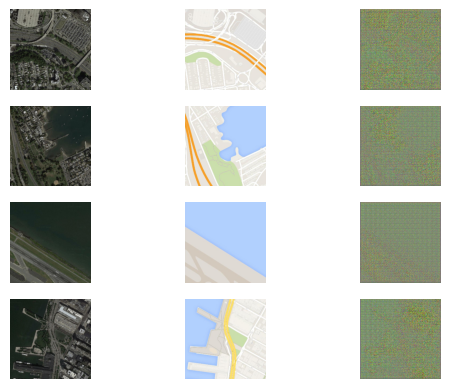

137/137 [==============================] - 205s 1s/step - d_loss: 5.8259e-06 - g_loss: 3.9019e-07
Epoch 14/15
137/137 [==============================] - ETA: 0s - d_loss: 5.4363e-06 - g_loss: 3.7974e-07

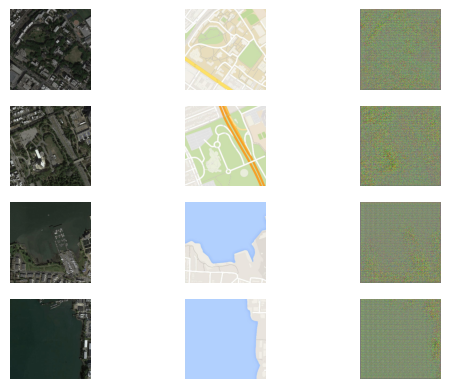

137/137 [==============================] - 204s 1s/step - d_loss: 5.4315e-06 - g_loss: 3.7865e-07
Epoch 15/15
137/137 [==============================] - ETA: 0s - d_loss: 4.9337e-06 - g_loss: 3.4512e-07

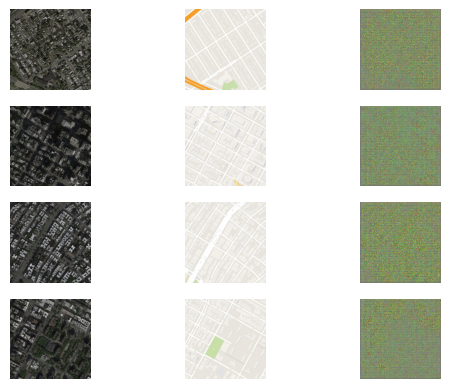

137/137 [==============================] - 205s 1s/step - d_loss: 4.9256e-06 - g_loss: 3.4579e-07


In [64]:
# 30-45 epochs
num_epochs = 15
p2p.fit(dataset, epochs=num_epochs,callbacks=[ShowResultsCallback()])

In [ ]:
# from tensorflow.keras.models import load_model
# num_epochs = 200
# if len(os.listdir(save_folder)) != 0:
#   checkpoint_path = os.path.join(save_folder, os.listdir(save_folder)[0])
#   initial_epochs = checkpoint_path.split('/')[-1].split('.')[0].split('_')[-1]
#   new_epochs = 200 - initial_epochs
#   p2p = load_model(checkpoint_path)
#   p2p.fit(dataset, epochs=new_epochs, initial_epochs=initial_epochs,callbacks=[SaveWeightsCallback(save_folder)])
# else:
#   p2p.fit(dataset, epochs=num_epochs, callbacks=[SaveWeightsCallback(save_folder)])

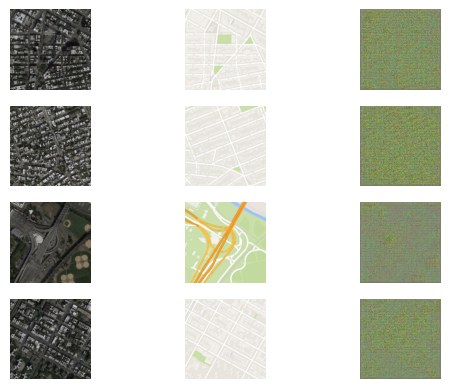

In [66]:
show_images()